Relational Schema Design & Justification

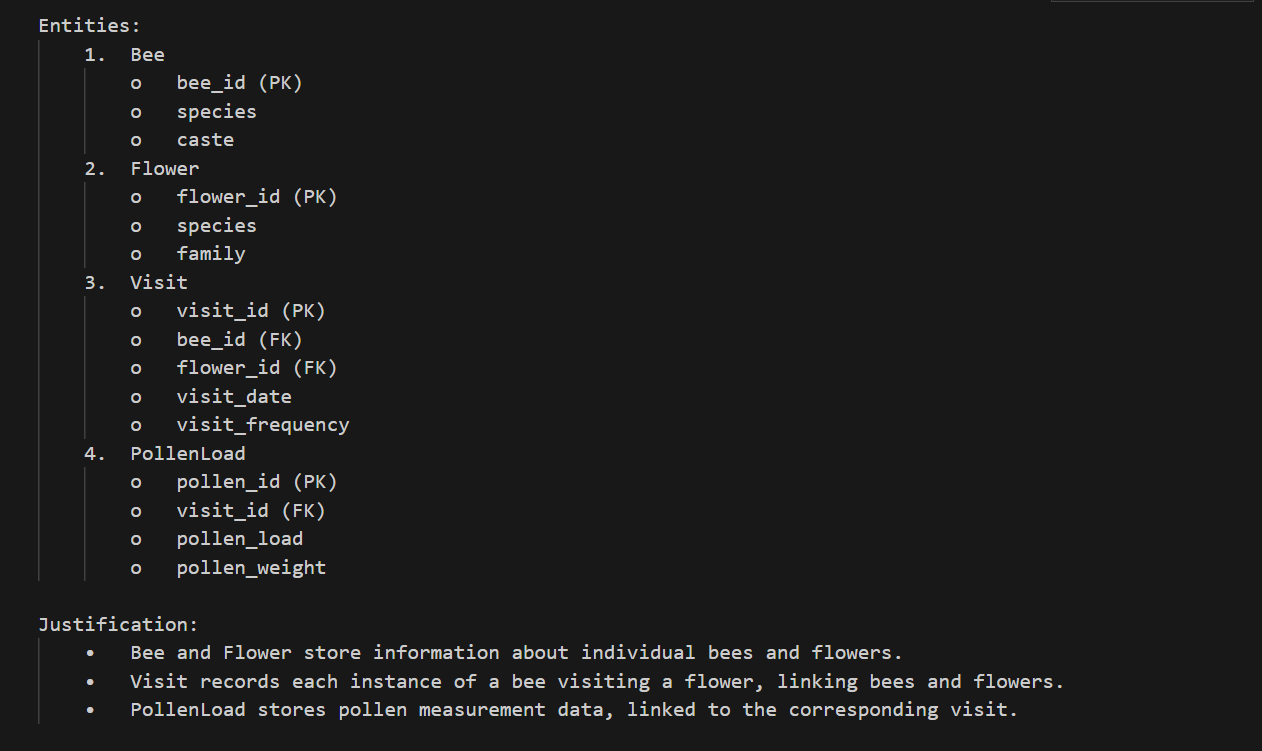
This schema allows analysis of pollen loads in the context of bee-flower interactions, supporting queries on species, visit frequency, and pollen metrics.
________________________________________
Entity-Relationship Diagram (ERD)

![Entity-Relationship Diagram showing Bee, Flower, Visit, and PollenLoad tables with their relationships. Bee table contains bee_id, species, and caste. Flower table contains flower_id, species, and family. Both connect to Visit table via foreign keys, which contains visit_id, bee_id, flower_id, visit_date, and visit_frequency. PollenLoad table links to Visit and contains pollen_id, visit_id, pollen_load, and pollen_weight. One bee and one flower are linked through many visits, and each visit can have associated pollen load data.](erd_image.png)



In [ ]:
%pip install pandas
import sqlite3
import pandas as pd


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [ ]:
conn = sqlite3.connect('bee_pollination.db')
c = conn.cursor()

c.execute('''
CREATE TABLE Bee (
    bee_id INTEGER PRIMARY KEY,
    species TEXT,
    caste TEXT
)
''')

c.execute('''
CREATE TABLE Flower (
    flower_id INTEGER PRIMARY KEY,
    species TEXT,
    color TEXT
)
''')

c.execute('''
CREATE TABLE Visit (
    visit_id INTEGER PRIMARY KEY,
    bee_id INTEGER,
    flower_id INTEGER,
    visit_date TEXT,
    visit_frequency INTEGER,
    FOREIGN KEY (bee_id) REFERENCES Bee(bee_id),
    FOREIGN KEY (flower_id) REFERENCES Flower(flower_id)
)
''')

c.execute('''
CREATE TABLE PollenLoad (
    pollen_id INTEGER PRIMARY KEY,
    visit_id INTEGER,
    pollen_load REAL,
    FOREIGN KEY (visit_id) REFERENCES Visit(visit_id)
)
''')

conn.commit()
conn.close()




In [ ]:
# 1. Find avg pollen load by bee species
import sqlite3
import pandas as pd

# Load your actual CSV files (adjust paths as needed)
flowers_df = pd.read_csv('../data/2013_2015_flower_visitation_data.csv') 
pollen_df = pd.read_csv('../data/2015_pollen_load_data.csv')

# Create an in-memory database
conn = sqlite3.connect(':memory:')

# Load DataFrames into the database
flowers_df.to_sql('flowers', conn, index=False)
pollen_df.to_sql('pollen', conn, index=False)

# Run your SQL query
query = """
SELECT f.species, AVG(p.Load) AS avg_pollen_load
FROM flowers f
JOIN pollen p ON f.species = p.species
GROUP BY f.species
"""

result = pd.read_sql_query(query, conn)
print(result)

# Close connection
conn.close()

                        Species  avg_pollen_load
0            Andrena alfkenella         0.875000
1               Andrena bicolor         0.633152
2           Andrena carantonica         0.949074
3          Andrena chrysosceles         0.699755
4             Andrena cineraria         0.454861
5               Andrena dorsata         0.660985
6              Andrena flavipes         0.778153
7                Andrena florea         0.916667
8                 Andrena fulva         0.833333
9            Andrena haemorrhoa         0.611426
10              Andrena helvola         0.250000
11              Andrena labiata         0.522727
12             Andrena minutula         0.446759
13         Andrena minutuloides         0.659091
14           Andrena nigroaenea         0.410985
15               Andrena nitida         0.825658
16           Andrena semilaevis         0.383809
17             Andrena subopaca         0.523438
18           Andrena trimmerana         1.000000
19             Andre

In [ ]:
def safe_sql_analysis(pollen_file, flowers_file):
    """Safely run SQL analysis with column name checking"""
    
    import sqlite3
    import pandas as pd
    
    # Load data
    pollen_df = pd.read_csv(pollen_file)
    flowers_df = pd.read_csv(flowers_file)
    
    print("Original column names:")
    print(f"Pollen DataFrame: {pollen_df.columns.tolist()}")
    print(f"Flowers DataFrame: {flowers_df.columns.tolist()}")
    
    # Create database
    conn = sqlite3.connect(':memory:')
    pollen_df.to_sql('pollen', conn, index=False)
    flowers_df.to_sql('flowers', conn, index=False)
    
    # Check actual table structure
    print("\nDatabase table columns:")
    pollen_info = pd.read_sql_query("PRAGMA table_info(pollen)", conn)
    flowers_info = pd.read_sql_query("PRAGMA table_info(flowers)", conn)
    
    print("Pollen table:", pollen_info['name'].tolist())
    print("Flowers table:", flowers_info['name'].tolist())
    
    # Build query with actual column names
    pollen_cols = pollen_info['name'].tolist()
    
    # Find the right columns
    species_col = 'Species' if 'Species' in pollen_cols else 'species'
    load_col = 'Load' if 'Load' in pollen_cols else 'pollen_load'
    
    query = f"""
    SELECT f.{species_col}, AVG(p.{load_col}) AS avg_pollen_load
    FROM flowers f
    JOIN pollen p ON f.{species_col} = p.{species_col}
    GROUP BY f.{species_col}
    """
    
    print(f"\nUsing query: {query}")
    
    result = pd.read_sql_query(query, conn)
    conn.close()
    
    return result

# Use the safe function
result = safe_sql_analysis('../data/2015_pollen_load_data.csv', '../data/2013_2015_flower_visitation_data.csv')
print(result)

Original column names:
Pollen DataFrame: ['Farm', 'Type', 'Round', 'Date', 'Species', 'Load', 'Netted on', 'Plant pollen', 'Status', 'Proportion', 'Weight']
Flowers DataFrame: ['Farm', 'Type', 'Round', 'Date', 'Species', 'Number', 'Caste', 'Visiting', 'Status', 'Purpose', 'Family']

Database table columns:
Pollen table: ['Farm', 'Type', 'Round', 'Date', 'Species', 'Load', 'Netted on', 'Plant pollen', 'Status', 'Proportion', 'Weight']
Flowers table: ['Farm', 'Type', 'Round', 'Date', 'Species', 'Number', 'Caste', 'Visiting', 'Status', 'Purpose', 'Family']

Using query: 
    SELECT f.Species, AVG(p.Load) AS avg_pollen_load
    FROM flowers f
    JOIN pollen p ON f.Species = p.Species
    GROUP BY f.Species
    
                        Species  avg_pollen_load
0            Andrena alfkenella         0.875000
1               Andrena bicolor         0.633152
2           Andrena carantonica         0.949074
3          Andrena chrysosceles         0.699755
4             Andrena cineraria      

In [ ]:
# 2. List bee species with highest avg pollen weight per visit
conn = sqlite3.connect(':memory:')
pollen_df.to_sql('pollen', conn, index=False)
flowers_df.to_sql('flowers', conn, index=False)

query = """
SELECT Species, AVG(CAST(Weight AS FLOAT)) AS avg_pollen_weight
FROM pollen
GROUP BY Species
ORDER BY avg_pollen_weight DESC
"""

result = pd.read_sql_query(query, conn)
print(result)
conn.close()

                        Species  avg_pollen_weight
0                 Osmia leaiana         100.000000
1             Melitta tricincta         100.000000
2      Lasioglossum puncticolle         100.000000
3            Andrena trimmerana         100.000000
4                Andrena florea          91.666667
5           Colletes daviesanus          87.500000
6           Andrena carantonica          61.574074
7      Lasioglossum leucozonium          52.370690
8       Lasioglossum villosulum          50.231481
9            Osmia caerulescens          50.000000
10             Melitta leporina          50.000000
11      Lasioglossum fulvicorne          50.000000
12             Andrena wilkella          50.000000
13                Andrena fulva          50.000000
14               Andrena nitida          49.013158
15         Andrena minutuloides          47.727273
16              Andrena dorsata          45.643939
17      Lasioglossum malachurum          44.958619
18              Andrena bicolor

In [ ]:
# 3. Count total visits and total pollen loads per flower family
conn = sqlite3.connect(':memory:')
pollen_df.to_sql('pollen', conn, index=False)
flowers_df.to_sql('flowers', conn, index=False)

query = """
SELECT f.Family, COUNT(*) AS total_visits, SUM(CAST(Load AS FLOAT)) AS total_pollen
FROM flowers f
JOIN pollen p ON f.Species = p.Species
GROUP BY f.Family
ORDER BY total_pollen DESC
"""

result = pd.read_sql_query(query, conn)
print(result)
conn.close()

             Family  total_visits  total_pollen
0        Asteraceae        442368   316931.9084
1          Apiaceae        109416    66809.9148
2          Rosaceae         14524     9845.4976
3      Boraginaceae         12524     9227.0000
4          Fabaceae         12396     9046.2500
5      Brassicaceae          9960     6911.8320
6     Ranunculaceae          9800     6680.5000
7       Geraniaceae          6200     4543.2500
8        Resedaceae          5032     3427.7492
9       Veroniaceae          5304     3329.2500
10   Convolvulaceae          3660     2595.0000
11     Polygonaceae          3340     2518.2500
12    Cucurbitaceae          3396     2484.7500
13        Lamiaceae          2416     1560.1664
14      Dipsacaceae          1704      975.0000
15   Caprifoliaceae          1016      628.0828
16        Cornaceae           916      620.6664
17    Euphorbiaceae           680      448.3328
18     Hypericaceae           540      285.0000
19  Caryophyllaceae           504      2

In [ ]:
# 4. Identify bee-flower pairs with above-average pollen load
conn = sqlite3.connect(':memory:')
pollen_df.to_sql('pollen', conn, index=False)
flowers_df.to_sql('flowers', conn, index=False)

query = """
SELECT f.Species AS bee_flower_species,
AVG(CAST(p.Load AS FLOAT)) AS avg_load
FROM pollen p
JOIN flowers f ON p.Species = f.Species
GROUP BY f.Species
HAVING avg_load > (
    SELECT AVG(CAST(Load AS FLOAT)) FROM pollen
)
ORDER BY avg_load DESC
"""

result = pd.read_sql_query(query, conn)
print(result)
conn.close()

          bee_flower_species  avg_load
0              Osmia leaiana  1.000000
1         Osmia caerulescens  1.000000
2          Melitta tricincta  1.000000
3           Melitta leporina  1.000000
4    Megachile centuncularis  1.000000
5   Lasioglossum puncticolle  1.000000
6        Anthophora plumipes  1.000000
7         Andrena trimmerana  1.000000
8        Andrena carantonica  0.949074
9             Andrena florea  0.916667
10      Lasioglossum zonulum  0.886364
11       Colletes daviesanus  0.875000
12        Andrena alfkenella  0.875000
13             Andrena fulva  0.833333
14            Andrena nitida  0.825658
15          Andrena flavipes  0.778153
16   Lasioglossum malachurum  0.750259
17   Lasioglossum laevigatum  0.750000
18  Lasioglossum leucozonium  0.743534
19      Andrena chrysosceles  0.699755
20          Andrena wilkella  0.666667
21           Andrena dorsata  0.660985
22      Andrena minutuloides  0.659091
